# Railway Track Fault Detection
---
|Subject:|Mathematical Modeling Practice|
|---|---|
|Semester:|Fall 2022|
|Name:|Tamás Demus|
|NEPTUN:|XP4B9D|
---

## Dataset
---
|Name:|Railway Track Fault Detection|
|---|---|
|Link to dataset:|https://www.kaggle.com/datasets/salmaneunus/railway-track-fault-detection|
---

Importing modules

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import cv2 as cv

from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tqdm import trange, tqdm
import os

2022-12-06 22:34:37.053334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 22:34:37.447729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/demust/py39/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-06 22:34:37.447757: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-06 22:34:39.568675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

Setting up environment

In [2]:
raw_folder = './raw/'
data_folder = './data/'
preprocessed_folder = './preprocessed/'

PATH = [
    'Train/Non defective/',
    'Train/Defective/',
    'Validation/Non defective/',
    'Validation/Defective/',
    'Test/Non defective/',
    'Test/Defective/',
]

RAW_PATH = [os.path.join(raw_folder, p) for p in PATH]
DATA_PATH = [os.path.join(data_folder, p) for p in PATH]
PREPROCESSED_PATH = [os.path.join(preprocessed_folder, p) for p in PATH]

for p in PREPROCESSED_PATH:
    if not os.path.exists(p):
        os.makedirs(p)
        
for p in DATA_PATH:
    if not os.path.exists(p):
        os.makedirs(p)

Check file types

In [3]:
ext = []

for p in RAW_PATH:
    for f in os.listdir(p):
        ext.append(os.path.splitext(f)[-1])
    
print(set(ext))

{'.webp', '.jpeg', '.jpg'}


Copying raw dataset with new filenames and converting the extensions

In [4]:
i = 0
p_new = 0
for p in RAW_PATH:
    for f in tqdm(os.listdir(p), desc=p):
        dst = os.path.join(DATA_PATH[p_new], str(i)+'.jpg')
        if not os.path.exists(dst):
            src = os.path.join(p, f)
            img = cv.imread(src)
            cv.imwrite(dst, img)
        i += 1
    p_new += 1


./raw/Test/Defective/: 100%|██████████| 11/11 [00:00<00:00, 9421.55it/s]


Creating image dataframe

In [15]:
images = pd.DataFrame({
    'type': pd.Series(dtype='str'),
    'defect': pd.Series(dtype='int'),
    'defect_str': pd.Series(dtype='str'),
    'path': pd.Series(dtype='str'),
    'filename': pd.Series(dtype='str'),
    'img': pd.Series(dtype='str'),
    'width': pd.Series(dtype='int'),
    'height': pd.Series(dtype='int'),
    'components': pd.Series(dtype='int')
})

for each in DATA_PATH:
    p = each.split('/')
    t = p[2].lower()
    if p[3] == 'Defective':
        y = 1
    else:
        y = 0
    for img in os.listdir(each):
        d = {
            'type': t,
            'defect': y,
            'defect_str': p[3],
            'path': each,
            'filename': img,
            'img': os.path.join(each, img),
            'width': 0,
            'height': 0,
            'components': 0
        }
        df = pd.DataFrame(data=d, index=[1])
        images = pd.concat([images, df])

images.reset_index(inplace=True, drop=True)
display(images)
images.info()

type  defect     defect_str                         path filename  \
0    train       0  Non defective  ./data/Train/Non defective/   97.jpg   
1    train       0  Non defective  ./data/Train/Non defective/   79.jpg   
2    train       0  Non defective  ./data/Train/Non defective/  114.jpg   
3    train       0  Non defective  ./data/Train/Non defective/   18.jpg   
4    train       0  Non defective  ./data/Train/Non defective/   46.jpg   
..     ...     ...            ...                          ...      ...   
379   test       1      Defective       ./data/Test/Defective/  381.jpg   
380   test       1      Defective       ./data/Test/Defective/  379.jpg   
381   test       1      Defective       ./data/Test/Defective/  377.jpg   
382   test       1      Defective       ./data/Test/Defective/  380.jpg   
383   test       1      Defective       ./data/Test/Defective/  375.jpg   

                                    img  width  height  components  
0     ./data/Train/Non defective/97.jpg      0       0           0  
1     ./data/Train/Non defective/79.jpg      0       0           0  
2    ./data/Train/Non defective/114.jpg      0       0           0  
3     ./data/Train/Non defective/18.jpg      0       0           0  
4     ./data/Train/Non defective/46.jpg      0       0           0  
..                                  ...    ...     ...         ...  
379       ./data/Test/Defective/381.jpg      0       0           0  
380       ./data/Test/Defective/379.jpg      0       0           0  
381       ./data/Test/Defective/377.jpg      0       0           0  
382       ./data/Test/Defective/380.jpg      0       0           0  
383       ./data/Test/Defective/375.jpg      0       0           0  

[384 rows x 9 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   type        384 non-null    object
 1   defect      384 non-null    int64 
 2   defect_str  384 non-null    object
 3   path        384 non-null    object
 4   filename    384 non-null    object
 5   img         384 non-null    object
 6   width       384 non-null    int64 
 7   height      384 non-null    int64 
 8   components  384 non-null    int64 
dtypes: int64(4), object(5)
memory usage: 27.1+ KB


Check the shape of the images

In [16]:
width = []
height = []
components = []

for i in tqdm(images.index):
    image = cv.imread(images.iloc[i].img)
    width.append(image.shape[0])
    height.append(image.shape[1])
    components.append(image.shape[2])

images.update({'width': width})
images.update({'height': height})
images.update({'components': components})

100%|██████████| 384/384 [02:45<00:00,  2.31it/s]


Minimum  width  :  148  @  243
Maximum  width  :  8000  @  241
Minimum  height  :  156  @  297
Maximum  height  :  8000  @  152
Minimum  components  :  3  @  0
Maximum  components  :  3  @  0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


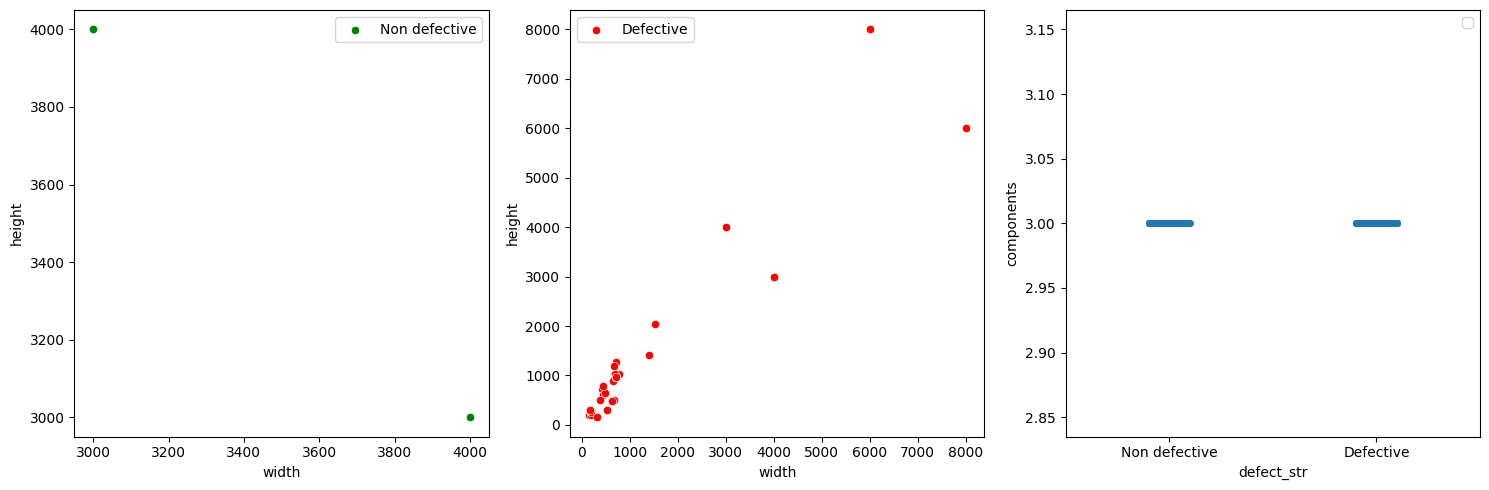

In [50]:
dims = ['width', 'height', 'components']
for dim in dims:
    print('Minimum ', dim, ' : ', images[dim].min(), ' @ ', images[dim].argmin())
    print('Maximum ', dim, ' : ', images[dim].max(), ' @ ', images[dim].argmax())

fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
sns.scatterplot(x='width', y='height', data=images[images.defect == 0], ax=ax[0], label='Non defective', color='green')
sns.scatterplot(x='width', y='height', data=images[images.defect == 1], ax=ax[1], label='Defective', color='red')
sns.stripplot(x='defect_str', y='components', data=images, ax=ax[2])
plt.show()

Check if dataset is balanced

In [44]:
images.groupby(['type', 'defect_str']).count()

defect  path  filename  img  width  height  \
type       defect_str                                                  
test       Defective          11    11        11   11     11      11   
           Non defective      11    11        11   11     11      11   
train      Defective         150   150       150  150    150     150   
           Non defective     150   150       150  150    150     150   
validation Defective          31    31        31   31     31      31   
           Non defective      31    31        31   31     31      31   

                          components  
type       defect_str                 
test       Defective              11  
           Non defective          11  
train      Defective             150  
           Non defective         150  
validation Defective              31  
           Non defective          31

Generating random sample from training data

In [45]:
N_samples = 4
random_sample_idx = []
for i in range(N_samples):
    idx = np.random.choice(images[images.type == 'train'].index)
    random_sample_idx.append(idx)
random_sample = images.iloc[random_sample_idx].copy()
random_sample

type  defect     defect_str                         path filename  \
134  train       0  Non defective  ./data/Train/Non defective/    4.jpg   
34   train       0  Non defective  ./data/Train/Non defective/   69.jpg   
65   train       0  Non defective  ./data/Train/Non defective/    0.jpg   
67   train       0  Non defective  ./data/Train/Non defective/   25.jpg   

                                   img  width  height  components  
134   ./data/Train/Non defective/4.jpg   4000    3000           3  
34   ./data/Train/Non defective/69.jpg   4000    3000           3  
65    ./data/Train/Non defective/0.jpg   3000    4000           3  
67   ./data/Train/Non defective/25.jpg   3000    4000           3

Visualizing random sample

100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


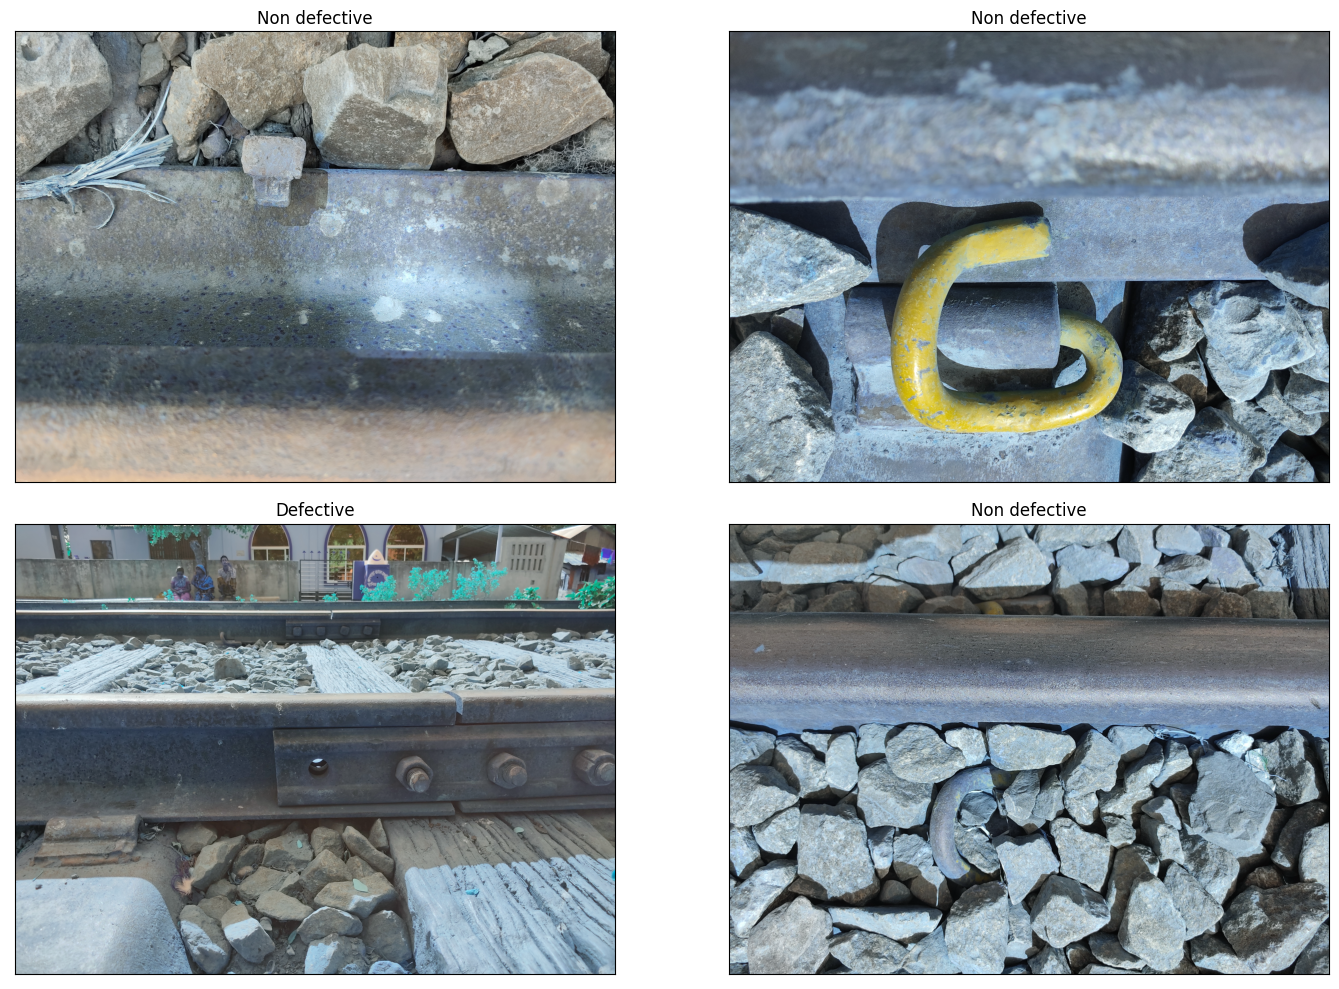

In [80]:
dim = np.ceil(np.sqrt(N_samples)).astype(int)
fig, ax = plt.subplots(dim, dim, figsize=(15, 10), tight_layout=True)
ax = ax.flatten()

for i, idx in enumerate(tqdm(random_sample.index)):
    image = cv.imread(images.img[idx])
    ax[i].imshow(image)
    ax[i].set_xticks(ticks=[])
    ax[i].set_yticks(ticks=[])
    ax[i].set_title(images.defect_str[idx])

plt.show()

Checking basic information on random sample: color components on RGB and HSV

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


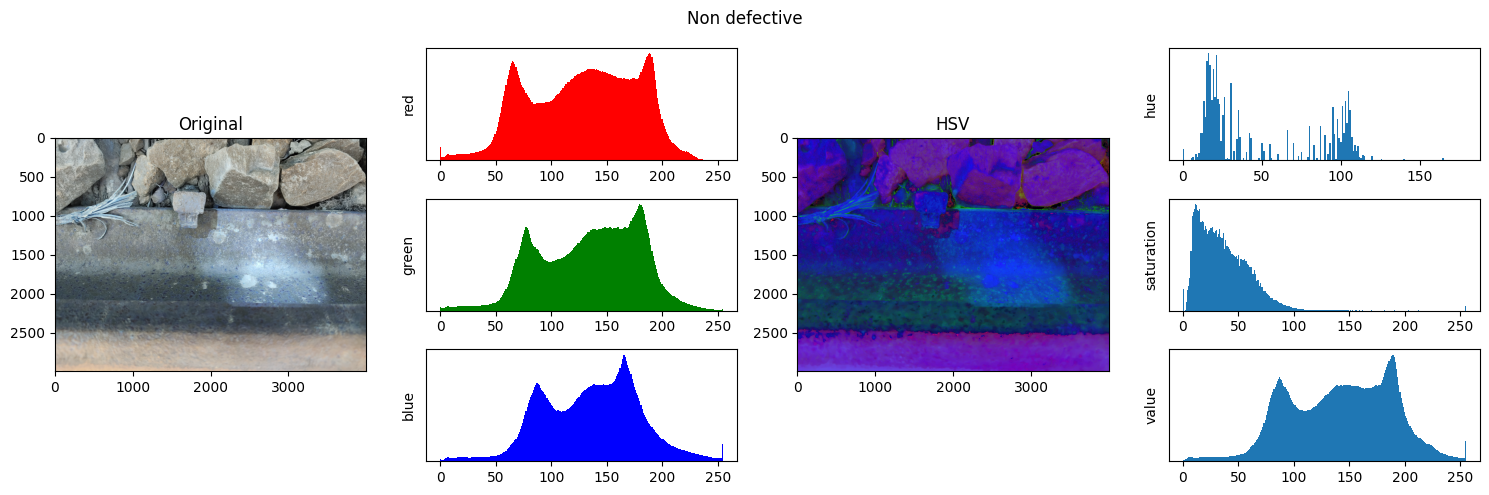

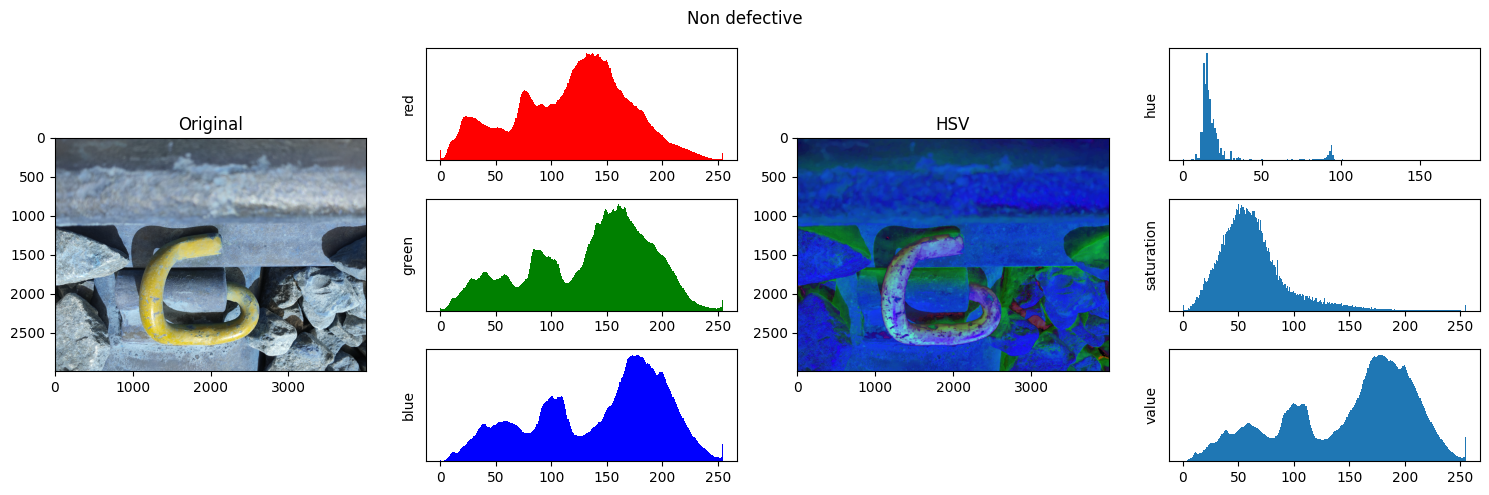

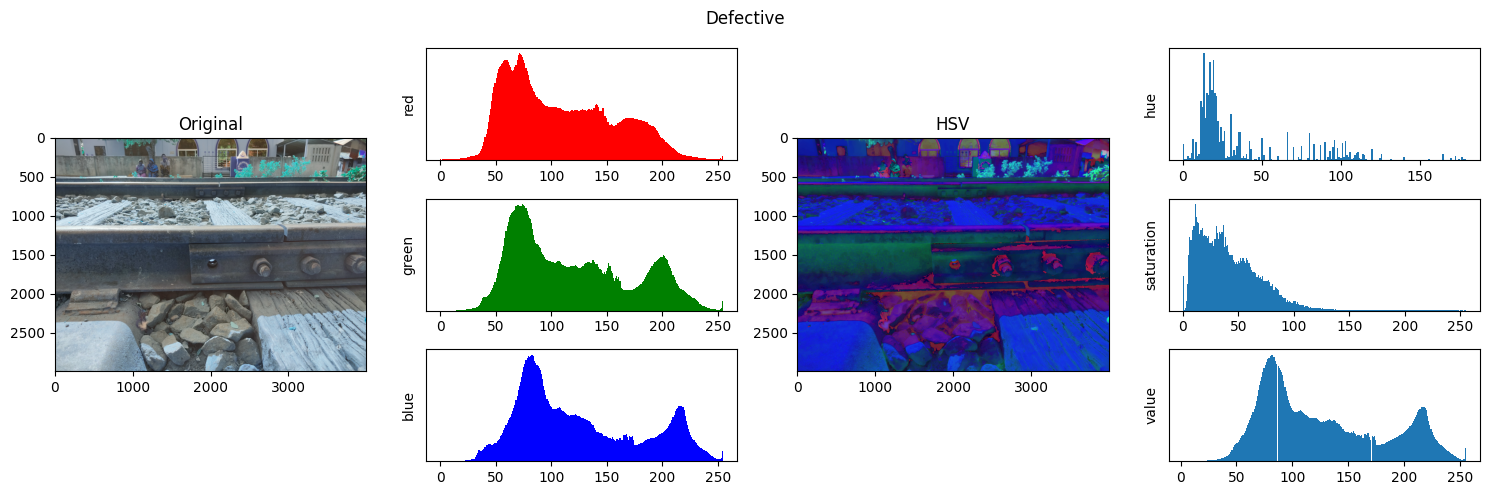

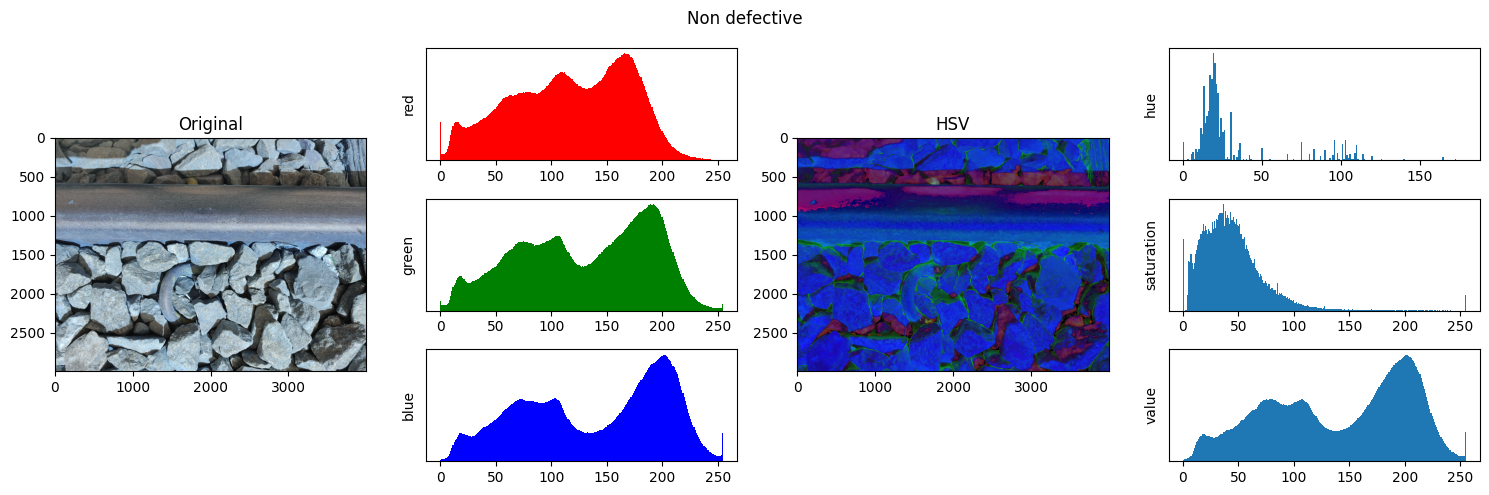

In [81]:
gs = gridspec.GridSpec(3, 4)

for each in tqdm(
    (
        random_sample[['img', 'defect_str']].to_numpy()
    ).tolist()
):
    fig = plt.figure(figsize=(15, 5), tight_layout=True)
    fig.suptitle(each[1])
    ax = [
        fig.add_subplot(gs[:, 0]),
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, 1]),
        fig.add_subplot(gs[:, 2]),
        fig.add_subplot(gs[0, 3]),
        fig.add_subplot(gs[1, 3]),
        fig.add_subplot(gs[2, 3]),
    ]
    image = cv.imread(each[0])
    ax[0].imshow(image)
    ax[0].set_title('Original')
    
    for c, component in enumerate(['red', 'green', 'blue']):
        ax[c+1].hist(image[:, :, c].ravel(), bins=256, color=component)
        ax[c+1].set_ylabel(component)
        ax[c+1].set_yticks([])
        
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    ax[4].imshow(hsv)
    ax[4].set_title('HSV')
    
    for c, component in enumerate(['hue', 'saturation', 'value']):
        bins = [180, 256, 256]
        ax[c+5].hist(hsv[:, :, c].ravel(), bins=bins[c])
        ax[c+5].set_ylabel(component)
        ax[c+5].set_yticks([])

We can consider a rail non-defective when it is not broken and there is proper mounting to the sleepers.

Idea: this might be detected via the continuity of the edges: on the top it should be continuous, at the bottom it should be periodically intersected by the mounting elements.

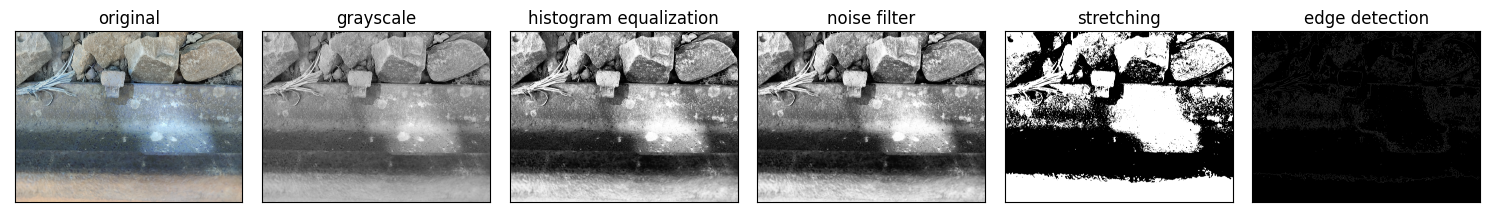

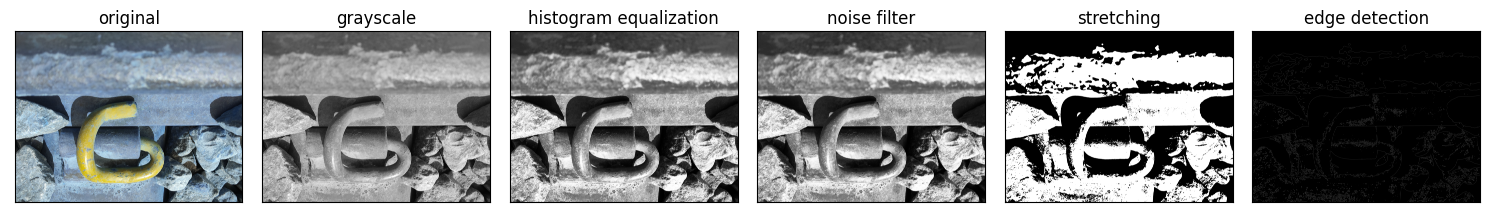

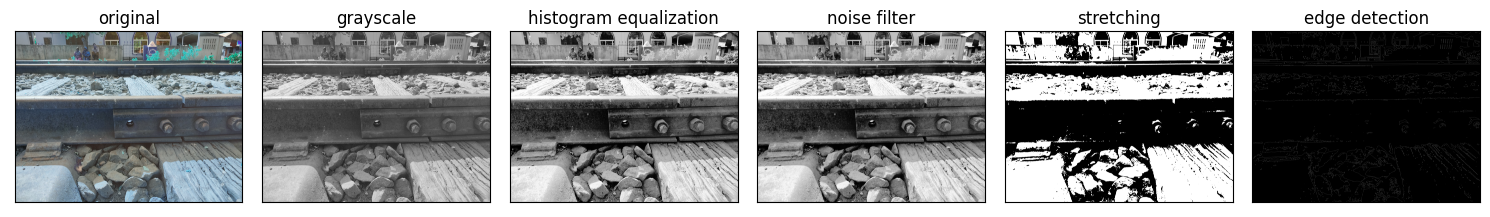

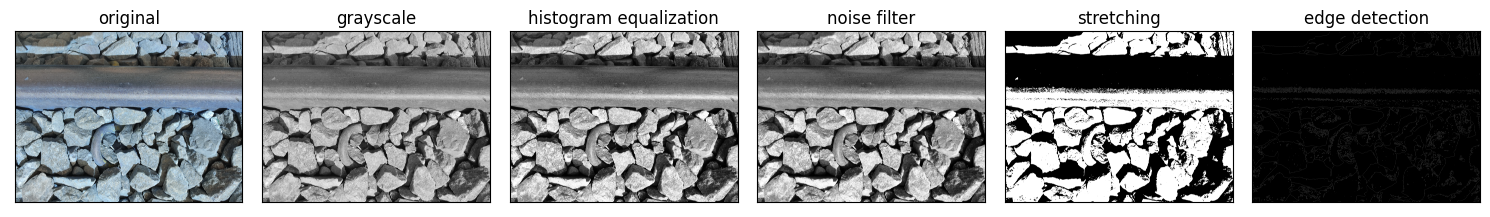

In [126]:
N_STEPS = 6
STEPS = ['original', 'grayscale', 'histogram equalization', 'noise filter', 'stretching', 'edge detection']

for sample in random_sample.itertuples():
    fig, ax = plt.subplots(1, N_STEPS, figsize=(15, 5), tight_layout=True)
    image = cv.imread(sample.img)
    grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    equalized = cv.equalizeHist(grayscale)
    filtered = cv.GaussianBlur(equalized, (11, 11), 0)
    stretched = cv.normalize(filtered, None, norm_type=cv.NORM_MINMAX)
    edge = cv.Laplacian(stretched, ddepth=cv.CV_16U, ksize=9)
    
    ax[0].imshow(image)
    ax[1].imshow(grayscale, cmap='gray')
    ax[2].imshow(equalized, cmap='gray')
    ax[3].imshow(filtered, cmap='gray')
    ax[4].imshow(stretched, cmap='gray')
    ax[5].imshow(edge, cmap='gray')
    
    for s, step in enumerate(STEPS):
        ax[s].set_xticks(ticks=[])
        ax[s].set_yticks(ticks=[])
        ax[s].set_title(step)

    plt.show()



Image processing pipeline

In [127]:
image_list = []
for i, img in enumerate(tqdm(images.img)):
    image = cv.imread(img)
    path = img.split('/')
    path[1] = preprocessed_folder
    dst = os.path.join(*path[1:])
    
    grayscale = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    equalized = cv.equalizeHist(grayscale)
    filtered = cv.GaussianBlur(equalized, (11, 11), 0)
    stretched = cv.normalize(filtered, None, norm_type=cv.NORM_MINMAX)
    edge = cv.Laplacian(stretched, ddepth=cv.CV_16U, ksize=9)
    
    cv.imwrite(dst, edge)

100%|██████████| 384/384 [05:58<00:00,  1.07it/s]


Loading preprocessed images for the neural network

In [128]:
batch_size = 32
img_height = 40
img_width = 40

train_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(preprocessed_folder, 'Train'),
    labels='inferred',
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(preprocessed_folder, 'Validation'),
    labels='inferred',
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

class_names = train_data.class_names
print('Class names: ', class_names)

Found 300 files belonging to 2 classes.
Found 62 files belonging to 2 classes.
Class names:  ['Defective', 'Non defective']


Data augmentation

Performance settings

In [129]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

Constructing neural network

In [130]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(units=int(img_height*img_width/2), activation='relu'),
    layers.Dense(units=int(img_height*img_width/4), activation='relu'),
    layers.Dense(len(class_names))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 64)       

Train the model

In [131]:
epochs = 10
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=epochs
)

Epoch 1/20
10/10 [==============================] - 119s 7s/step - loss: 5.6976 - accuracy: 0.5200 - val_loss: 0.7065 - val_accuracy: 0.5000
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.5167

2022-12-06 22:04:23.041061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 51 of 256
2022-12-06 22:04:24.221624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


10/10 [==============================] - 73s 7s/step - loss: 0.6950 - accuracy: 0.5167 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 3/20
10/10 [==============================] - 54s 5s/step - loss: 0.6846 - accuracy: 0.6500 - val_loss: 0.6919 - val_accuracy: 0.6290
Epoch 4/20
10/10 [==============================] - 54s 5s/step - loss: 0.6609 - accuracy: 0.7600 - val_loss: 0.6871 - val_accuracy: 0.4839
Epoch 5/20


2022-12-06 22:06:23.195775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 229 of 256
2022-12-06 22:06:23.438442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


10/10 [==============================] - 64s 6s/step - loss: 0.5696 - accuracy: 0.7700 - val_loss: 0.6706 - val_accuracy: 0.5968
Epoch 6/20
10/10 [==============================] - 52s 5s/step - loss: 0.3710 - accuracy: 0.8367 - val_loss: 0.6506 - val_accuracy: 0.6935
Epoch 7/20
10/10 [==============================] - 55s 5s/step - loss: 0.1849 - accuracy: 0.9500 - val_loss: 0.7508 - val_accuracy: 0.6290
Epoch 8/20
10/10 [==============================] - 66s 7s/step - loss: 0.0691 - accuracy: 0.9833 - val_loss: 0.8374 - val_accuracy: 0.6935
Epoch 9/20
10/10 [==============================] - 51s 5s/step - loss: 0.0221 - accuracy: 1.0000 - val_loss: 0.9701 - val_accuracy: 0.6452
Epoch 10/20


2022-12-06 22:11:11.441839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 85 of 256
2022-12-06 22:11:15.338870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


10/10 [==============================] - 56s 4s/step - loss: 0.0236 - accuracy: 0.9933 - val_loss: 0.8552 - val_accuracy: 0.6452
Epoch 11/20


2022-12-06 22:12:07.456022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 94 of 256
2022-12-06 22:12:14.697312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


10/10 [==============================] - 44s 3s/step - loss: 0.0075 - accuracy: 0.9967 - val_loss: 0.9104 - val_accuracy: 0.6935
Epoch 12/20


2022-12-06 22:12:51.808666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 94 of 256
2022-12-06 22:13:01.435412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 187 of 256
2022-12-06 22:13:08.444581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


10/10 [==============================] - 62s 3s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.0232 - val_accuracy: 0.6613
Epoch 13/20
10/10 [==============================] - 60s 5s/step - loss: 8.6693e-04 - accuracy: 1.0000 - val_loss: 0.9975 - val_accuracy: 0.6613
Epoch 14/20
 2/10 [=====>........................] - ETA: 47s - loss: 5.5647e-04 - accuracy: 1.0000 

KeyboardInterrupt: 

Metrics

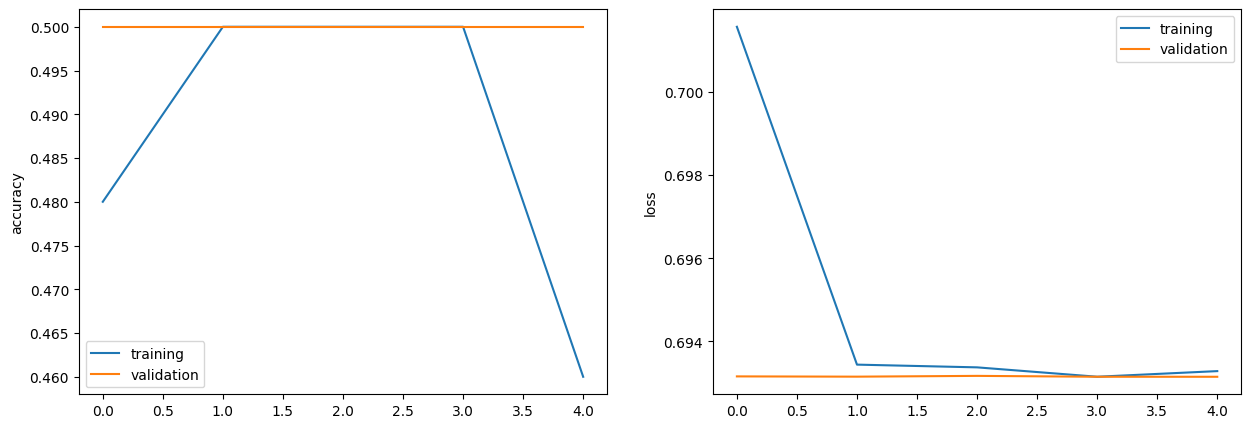

: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x=np.arange(epochs), y='accuracy', data=history.history, ax=ax[0], label='training')
sns.lineplot(x=np.arange(epochs), y='val_accuracy', data=history.history, ax=ax[0], label='validation')
sns.lineplot(x=np.arange(epochs), y='loss', data=history.history, ax=ax[1], label='training')
sns.lineplot(x=np.arange(epochs), y='val_loss', data=history.history, ax=ax[1], label='validation')
plt.show()

Predictions

Found 22 files belonging to 2 classes.
2/2 [==============================] - 5s 121ms/step


ValueError: Found input variables with inconsistent numbers of samples: [6, 22]

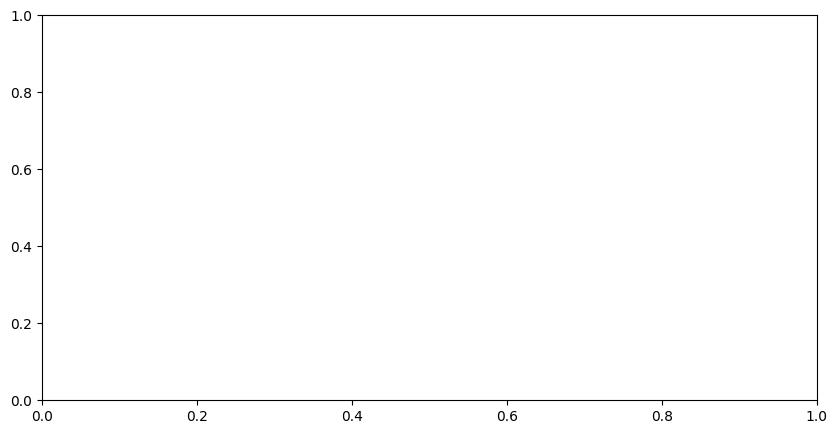

: 

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(preprocessed_folder, 'Test'),
    labels='inferred',
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

predictions = model.predict(test_data)
score = tf.nn.softmax(predictions)
y_pred = np.argmax(predictions, axis=1)
y_true = np.array(list(test_data.take(-1))[-1][-1])

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names, ax=ax, cmap='crest', colorbar=False)


: 